Performance testing with the generation of graphics to show diferences

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from gui.car import Car,generateRandomColor
import graph.graph_parser as gp
from graph.node import Node
from algorithms.bfs import BFS
from algorithms.dfs import DFS
from algorithms.a_star import A_STAR
from statistics import mean 
import pandas as pd
import pygame
import os
import random
import time
import sys

Set Static Variables

In [8]:
sys.setrecursionlimit(10**6)
NumberOfCars=3
StatisticsToShow=['TimeCost','Distance','TopSpeed','AvgSpeed','MedSpeed','StdSpeed','VarSpeed','P25Speed','P50Speed','P75Speed']#TimeCost,Distance,TopSpeed,AvgSpeed,MedSpeed,StdSpeed,VarSpeed,P25Speed,P50Speed,P75Speed

Find all circuits that exist
circuits will have the format (Name,File path)

In [9]:
circuits=[]
with os.scandir('gui/circuits/') as circuitsFiles:
    for circuit in circuitsFiles:
        name=circuit.name
        trackName=name.split('.')[0]
        circuits.append((trackName,f'gui/circuits/{name}'))

Get all the algoriths that will be used
algorithms will have the format (Name,class object)

In [10]:
algorithms=[
    ("Depth First Search",DFS()),
    ("Breath First Search",BFS()),
    ("A*",A_STAR())
    ]

Helper Functions to make the simulation and creating the graph from the sircuit file

In [11]:
def getMatrix(inputImage):
        """
           creates surfaces for the track components and defines max timeline position
        """
        image =  pygame.image.load(inputImage)
        resized_image=pygame.transform.scale(image,(100,50))
        greens=pygame.mask.from_threshold(resized_image,(0,255,0),threshold=(30, 50, 30, 255))
        reds=pygame.mask.from_threshold(resized_image,(255,0,0),threshold=(50, 30, 30, 255))
        blacks=pygame.mask.from_threshold(resized_image,(0,0,0),threshold=(100, 100, 100, 255))
    
        matrix=[]
        for r in range(50):
            f=''
            for c in range(100):
                if greens.get_at((c,r)):
                    f+='P'
                elif reds.get_at((c,r)):
                    f+='F'
                elif blacks.get_at((c,r)):
                    f+='-'
                else:
                    f+='X'
            matrix.append(f)
        return matrix



def getGraphFromImage(inputImage):
    matrix = getMatrix(inputImage)
    graph=gp.circuit_from_matrix(matrix)
    return graph

def simulate(algorithm,graph):
    """
       Uses the algorithm in the track to simulate the car
    """
    cars=[]
    for i in range(NumberOfCars):
        startingNode=random.choice(graph.starts)
        start=time.time()
        d = algorithm.search(graph, Node(startingNode[0], startingNode[1], 0, 0), graph.finishes)
        if d:
            cost,nodes=d
            end=time.time()
            c=Car(color=generateRandomColor(),tlen=cost)
            c.fromNodes(nodes)
            cars.append((end-start,c))
    return cars

Data structure

```javascript
{
    'VAR:algorithm':{
        'VAR:circuit':
            {
            'TimeCost':[FLOAT],
            'Distance':[FLOAT],
            'TopSpeed':[FLOAT],
            'AvgSpeed':[FLOAT],
            'MedSpeed':[FLOAT],
            'StdSpeed':[FLOAT],
            'VarSpeed':[FLOAT],
            'P25Speed':[FLOAT],
            'P50Speed':[FLOAT],
            'P75Speed':[FLOAT]
            },
    }
}
```



In [13]:
data={}
for algorithmN,algorithmI in algorithms:
    data[algorithmN]={}
    for circuitN,circuitF in circuits:
        print(algorithmN,circuitN)
        data[algorithmN][circuitN]={
            'TimeCost':[],
            'Distance':[],
            'TopSpeed':[],
            'AvgSpeed':[],
            'MedSpeed':[],
            'StdSpeed':[],
            'VarSpeed':[],
            'P25Speed':[],
            'P50Speed':[],
            'P75Speed':[]
        }
        
        
        graph=getGraphFromImage(circuitF)
        cars=simulate(algorithmI,graph)
        
        for cost,car in cars:
            data[algorithmN][circuitN]['TimeCost'].append(cost),
            data[algorithmN][circuitN]['Distance'].append(car.tlen),
            data[algorithmN][circuitN]['TopSpeed'].append(car.getTopSpeed()),
            data[algorithmN][circuitN]['AvgSpeed'].append(car.getAverageSpeed()),
            data[algorithmN][circuitN]['MedSpeed'].append(car.getMedian()),
            data[algorithmN][circuitN]['StdSpeed'].append(car.getStd()),
            data[algorithmN][circuitN]['VarSpeed'].append(car.getVar()),
            data[algorithmN][circuitN]['P25Speed'].append(car.get25Percentil()),
            data[algorithmN][circuitN]['P50Speed'].append(car.get50Percentil()),
            data[algorithmN][circuitN]['P75Speed'].append(car.get75Percentil())

Depth First Search drag
Depth First Search spielberg
Depth First Search overkill
Depth First Search melbourne
Depth First Search montreal
Depth First Search austin
Depth First Search barcelona
Depth First Search imola
Depth First Search bahrain
Depth First Search badImage
Depth First Search silverstone
Depth First Search mexico
Depth First Search budapest
Breath First Search drag
Breath First Search spielberg
Breath First Search overkill
Breath First Search melbourne
Breath First Search montreal
Breath First Search austin
Breath First Search barcelona
Breath First Search imola
Breath First Search bahrain
Breath First Search badImage
Breath First Search silverstone
Breath First Search mexico
Breath First Search budapest
A* drag
A* spielberg
A* overkill
A* melbourne
A* montreal
A* austin
A* barcelona
A* imola
A* bahrain
A* badImage
A* silverstone
A* mexico
A* budapest


Concise the data given to only filter for average distance and speed
```javascript
{'VAR:algorithm':{
    'VAR:circuit':{
        'TimeCost':Float
        'Distance':Float
        'TopSpeed':Float
        'AvgSpeed':Float
        'MedSpeed':Float
        'StdSpeed':Float
        'VarSpeed':Float
        'P25Speed':Float
        'P50Speed':Float
        'P75Speed':Float
        }
    }
}
```

In [14]:
AVGData={}

for alg,algData in data.items():
    AVGData[alg]={}
    for circuit,data in algData.items():
        AVGData[alg][circuit]={}
        for key in data.keys():
            AVGData[alg][circuit][key]=mean(data[key])

Selects only some of the statistics from the data

In [15]:
def unbloat(bloat):
    unblotedData={}
    for alg,algData in bloat.items():
        unblotedData[alg]={}
        for circuit,bloatedData in algData.items():
            unblotedData[alg][circuit]={}
            for key in StatisticsToShow:
                unblotedData[alg][circuit][key]=bloatedData[key]
    return unblotedData

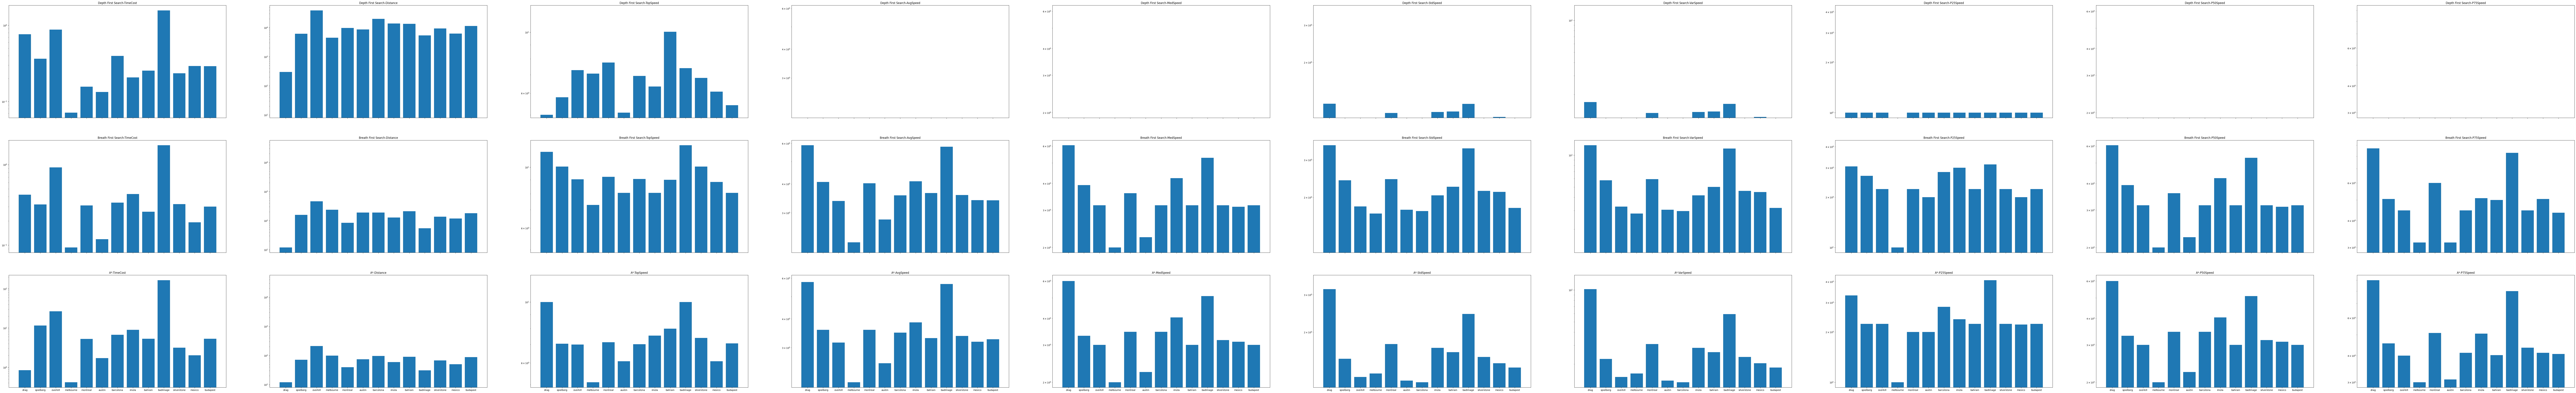

In [16]:

dataToPlot=unbloat(AVGData)

XAxisN=len(StatisticsToShow)
YAxisN=len(dataToPlot)


fig, axs = plt.subplots(YAxisN,XAxisN,sharex=True,figsize=(20*XAxisN,10*YAxisN))
fig.set_dpi(100)

for plotRow,(algName,algData) in enumerate(dataToPlot.items()):
    xAxis=algData.keys()
    for plotColumn,statistic in enumerate(StatisticsToShow):
        yAxis=[algData[key][statistic] for key in xAxis]
        axs[plotRow,plotColumn].set_title(f"{algName}-{statistic}")
        if plotColumn!=0:
            axs[plotRow,plotColumn].sharey(axs[0, plotColumn])
        
        axs[plotRow,plotColumn].set_yscale('log')
        axs[plotRow,plotColumn].bar(xAxis,yAxis)
